Counting train and test directory's length

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras import models

BASE_DIR = '/media/abel/TERA/School/5to/IA/IA Project/fer2013'
TRAIN_DIR = os.path.join(BASE_DIR,'train')
TEST_DIR = os.path.join(BASE_DIR,'test')

total_train = 0
total_test = 0

for e in os.listdir(TRAIN_DIR):
    total_train +=  len(os.listdir(os.path.join(TRAIN_DIR,e)))

for e in os.listdir(TEST_DIR):
    total_test +=  len(os.listdir(os.path.join(TEST_DIR,e)))

print('train length:',total_train)
print('test length:',total_test)


train length: 28709
test length: 7178


Crear generador de imágenes. Nos permite configurar rápidamente
generadores de python que pueden convertir automáticamente archivos de imagen en el disco en
batches de tensores preprocesados.
flow_from_directory recibe:
- Directorio con imágenes.
- Cantidad de imágenes por batch.
- Rescalado de las imágenes.
- Determina el tipo de array de etiquetas a devolver. En este caso categorical porque usaremos sparse_categorical_crossentropy como nuestra función de pérdida.

In [9]:
import cv2
import tensorflow as tf

categories = ['angry','disgust','fear','happy','neutral','sad','surprise']  # will use this to convert prediction num to string value


def prepare(filepath):
    IMG_SIZE = 48  
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) 
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [14]:
new_model =models.load_model('emotions_rec_2.h5')
prediction = new_model.predict([prepare('/media/abel/TERA/School/5to/IA/IA Project/fer2013/test/neutral/PrivateTest_932822.jpg')])
print(categories[int(np.argmax(prediction[0]))])


1/1 [==============================] - 0s 122ms/step
neutral


In [16]:
img_size = 150
batch_size = 32
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory(directory=TRAIN_DIR,
                                                 target_size=(img_size, img_size),
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator=datagen_validation.flow_from_directory(directory=TEST_DIR,
                                                 target_size=(img_size, img_size),
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=False)

# train_generator = train_datagen.flow_from_directory(
# TRAIN_DIR,
# target_size=(150, 150),
# batch_size=22,
# class_mode='categorical')

# valid_generator = test_datagen.flow_from_directory(
# TEST_DIR,
# target_size=(150, 150),
# batch_size=21,
# class_mode="categorical")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
images_batch, labels_batch = train_generator.next()
img = images_batch[0]
img = tf.image.rgb_to_grayscale(img)
img =  tf.keras.utils.img_to_array(img)
img = img.reshape((1,) + img.shape)
print(tf.shape(img))

# print(new_model.predict(img))
# print(np.argmax(labels_batch[0]))


InvalidArgumentError: Matrix size-incompatible: In[0]: [22500,1], In[1]: [3,1] [Op:MatMul]

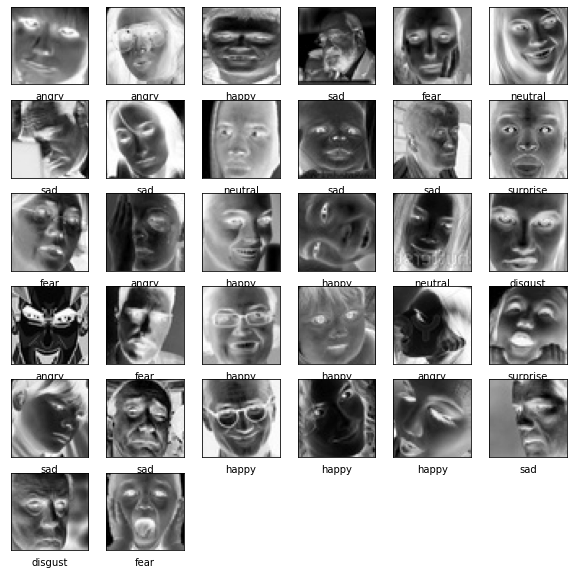

In [18]:


plt.figure(figsize=(10,10))
images_batch, labels_batch = train_generator.next()

print()
for i,p in enumerate(images_batch):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(p), cmap=plt.cm.binary)
    plt.xlabel(list(train_generator.class_indices.keys())[np.argmax(labels_batch[i])])

#### Building the model
En la siguiente sección se define la arquitectura de la red neuronal convolusional.
Para ello se colocan una serie de capas convolucionales 2d seguidas de capas maxpooling. El output de la última capa de convolución se aplana para obtner una entrada de una sola dimensión. Esta se pasa a una red neuronal encargada de determinar la emoción más probable dada una foto inicial.

In [19]:
from keras import layers
from keras import models
# from keras import regularizers

def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3),padding='same' ,activation='relu',input_shape=(img_size, img_size, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64, (3, 3),padding='same' , activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())


    model.add(layers.Conv2D(128, (3, 3),padding='same' , activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())


    model.add(layers.Conv2D(128, (3, 3),padding='same' , activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())


    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Dense(7, activation='softmax'))

    return model

cnn_model = build_cnn_model()
print(cnn_model.summary())



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 18, 18, 128)     

#### Compilation process
Definimos la función de pérdida, el optimizador y las métricas como el learning rate; empleando la función compile.

In [20]:
from keras import optimizers
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=5e-4),#usar sgd
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Train the model

In [23]:
history = cnn_model.fit(
        train_generator,
        batch_size=batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

cnn_model.save('emotions_rec_1.0.h5')

Epoch 1/30
898/898 [==============================] - 21s 23ms/step - loss: 1.7439 - accuracy: 0.2951 - val_loss: 2.0574 - val_accuracy: 0.1344
Epoch 2/30
898/898 [==============================] - 21s 23ms/step - loss: 1.7226 - accuracy: 0.3066 - val_loss: 2.0231 - val_accuracy: 0.1225
Epoch 3/30
898/898 [==============================] - 21s 23ms/step - loss: 1.7028 - accuracy: 0.3191 - val_loss: 2.1044 - val_accuracy: 0.0494
Epoch 4/30
898/898 [==============================] - 21s 23ms/step - loss: 1.6281 - accuracy: 0.3640 - val_loss: 2.0590 - val_accuracy: 0.0731
Epoch 5/30
898/898 [==============================] - 21s 23ms/step - loss: 1.5112 - accuracy: 0.4198 - val_loss: 1.8661 - val_accuracy: 0.1675
Epoch 6/30
898/898 [==============================] - 21s 23ms/step - loss: 1.4178 - accuracy: 0.4619 - val_loss: 1.9422 - val_accuracy: 0.1981
Epoch 7/30
898/898 [==============================] - 21s 23ms/step - loss: 1.3390 - accuracy: 0.4906 - val_loss: 1.6628 - val_accuracy:

#### Plot tranning process

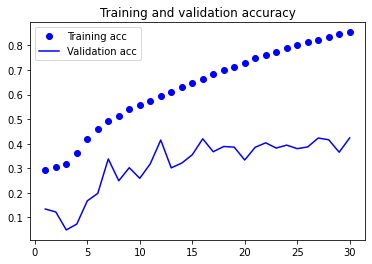

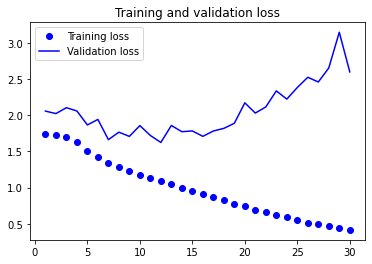

In [24]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Test the model

In [25]:
score = cnn_model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

225/225 [==============================] - 4s 17ms/step - loss: 2.1459 - accuracy: 0.5093
Test loss: 2.1458539962768555
Test accuracy: 0.5093340873718262
